In [180]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader
import seaborn as sns
import os
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
import random

In [181]:
#from google.colab import drive
#drive.mount('/content/drive')

In [182]:
train = {}
test = {}

test['data'] = pd.read_csv('/content/drive/MyDrive/HW2_data/Q3_test.csv')
train['data'] = pd.read_csv('/content/drive/MyDrive/HW2_data/Q3_train.csv')

In [183]:
rand_index = []
for i in range(9):
  rand_index.append(random.randint(0, len(train['data'])))

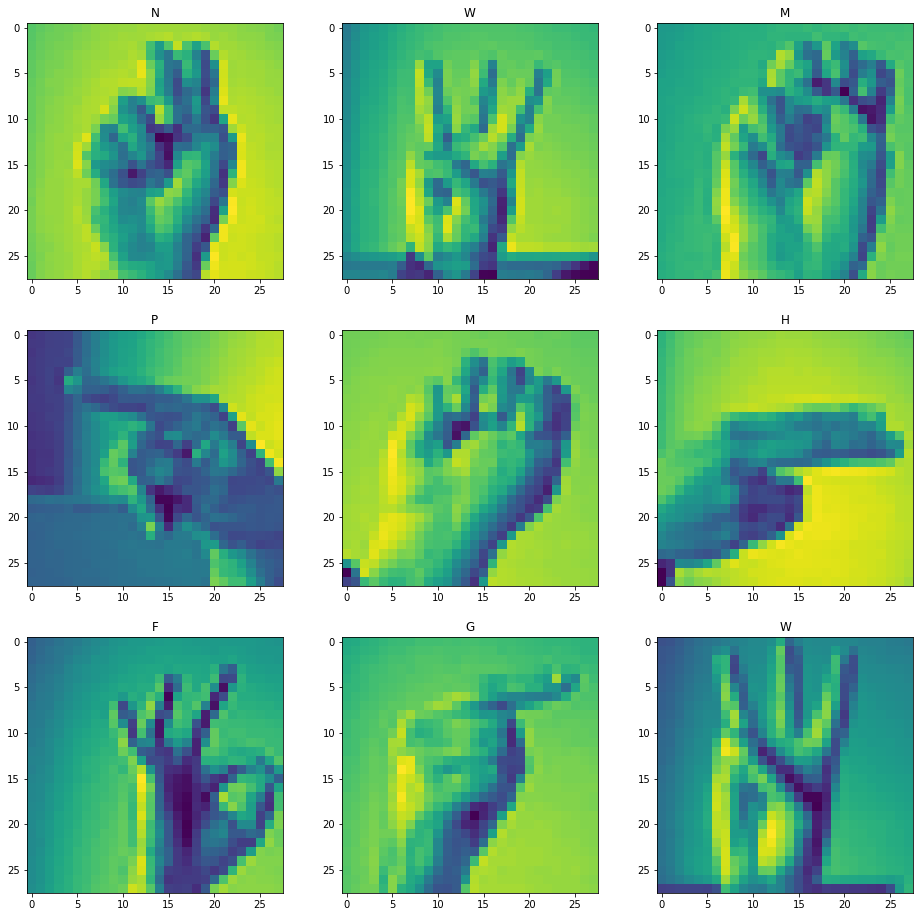

In [184]:
label = train['data'].iloc[rand_index][['label']].reset_index(drop=True)
picture = train['data'].iloc[rand_index].drop(['label'], axis=1).values
plt.figure(figsize=(16, 16)) 
for i in range(9):
  plt.subplot(3, 3, i+1)
  p = picture[i].reshape(28,28)
  plt.imshow(p)
  plt.title(chr(65 + label.iloc[i].item()))
plt.show()

In [185]:
val = {'size': 300, 'index':[]}
for i in range(val['size']):
  val['index'].append(random.randint(0, len(train['data'])))

def normalization(x):
   y = (x - np.mean(x)) / (np.max(x) - np.min(x))
   return y

val['img'] = normalization(train['data'].iloc[val['index']].drop(['label'], axis=1).values)
train['img'] = normalization(train['data'].drop(val['index'], axis=0).drop(['label'], axis=1).values)
test['img'] = normalization(test['data'].drop(['label'], axis=1).values)


val['label'] = train['data'].iloc[val['index']]['label'].values
train['label'] = train['data']['label'].drop(val['index'], axis=0).values
test['label'] = test['data']['label'].values

In [186]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class WithoutDropout(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 26)
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits


class WithDropout(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Dropout(p=0.7),
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 26),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

model_11 = WithoutDropout().to(device)
model_21 = WithoutDropout().to(device)

model_12 = WithDropout().to(device)
model_22 = WithDropout().to(device)

Using cpu device


In [187]:
class Mydataset(Dataset):
    def __init__(self, img, label):
        self.img = img
        self.label = label


    def __len__(self):
        return len(self.label)


    def __getitem__(self, idx):
        image = torch.tensor(self.img[idx], dtype=torch.float, requires_grad=True)
        label = self.label[idx]
        return image, label

In [188]:
train['dataset'] = Mydataset(train['img'], train['label'])
val['dataset'] = Mydataset(val['img'], val['label'])
test['dataset'] = Mydataset(test['img'], test['label'])


train['dataloader'] = DataLoader(train['dataset'], batch_size=64, shuffle=True)
val['dataloader'] = DataLoader(val['dataset'], batch_size=val['size'], shuffle=True)
test['dataloader'] = DataLoader(test['dataset'], batch_size=len(test['data']), shuffle=True)

In [189]:
loss_fn = nn.CrossEntropyLoss()
lr_SGD = 0.2
lr_Adam = 0.0005

optimizer_11 = torch.optim.SGD(model_11.parameters(), lr=lr_SGD)
optimizer_21 = torch.optim.Adam(model_21.parameters(), lr=lr_Adam)

optimizer_12 = torch.optim.SGD(model_12.parameters(), lr=lr_SGD)
optimizer_22 = torch.optim.Adam(model_22.parameters(), lr=lr_Adam)

In [190]:
def train_fun(dataloader, model, loss_fn, optimizer):
    size, l = len(dataloader.dataset), 0
    
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        model.train()
        pred = model(X)
        loss = loss_fn(pred, y)
        l += loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        
    l = l.item()
    print(f"loss: {l/size:>7f} ")

In [191]:
def test_fun(dataloader, model, loss_fn, d):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            model.eval()
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Accuracy_{d}: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} ")
    return 100*correct 

In [192]:
epochs = 21
accuracy = {}
accuracy['SGD with dropout'] = []
accuracy['Adam with dropout']= []
accuracy['SGD without dropout'] = []
accuracy['Adam without dropout'] = []
for t in range(epochs):
    print(f" Epoch {t+1}\n        SGD  without dropout\n-------------------------------")
    train_fun(train['dataloader'], model_11, loss_fn, optimizer_11)
    test_fun(val['dataloader'], model_11, loss_fn,'val')
    accuracy['SGD without dropout'].append(test_fun(test['dataloader'], model_11, loss_fn,'test'))

    print(f"\n        ADAM  without dropout\n-------------------------------")
    train_fun(train['dataloader'], model_21, loss_fn, optimizer_21)
    test_fun(val['dataloader'], model_21, loss_fn,'val')
    accuracy['Adam without dropout'].append(test_fun(test['dataloader'], model_21, loss_fn,'test'))

    print(f"\n        SGD  with dropout\n-------------------------------")
    train_fun(train['dataloader'], model_12, loss_fn, optimizer_12)
    test_fun(val['dataloader'], model_12, loss_fn,'val')
    accuracy['SGD with dropout'].append(test_fun(test['dataloader'], model_12, loss_fn,'test'))

    print(f"\n        ADAM  with dropout\n-------------------------------")
    train_fun(train['dataloader'], model_22, loss_fn, optimizer_22)
    test_fun(val['dataloader'], model_22, loss_fn,'val')
    accuracy['Adam with dropout'].append(test_fun(test['dataloader'], model_22, loss_fn,'test'))
    print('\n\n***************************************************************************************')
    if t == 5*epochs / 7:
        optimizer_11 = torch.optim.SGD(model_11.parameters(), lr=lr_SGD/2)
        optimizer_21 = torch.optim.Adam(model_21.parameters(), lr=lr_Adam/2)

        optimizer_12 = torch.optim.SGD(model_12.parameters(), lr=lr_SGD/2)
        optimizer_22 = torch.optim.Adam(model_22.parameters(), lr=lr_Adam/2)
    #if t == 4*epochs / 5:
        #optimizer_11 = torch.optim.SGD(model_11.parameters(), lr=lr_SGD/3)
        #optimizer_21 = torch.optim.Adam(model_21.parameters(), lr=lr_Adam/3)

        #optimizer_12 = torch.optim.SGD(model_12.parameters(), lr=lr_SGD/3)
        #optimizer_22 = torch.optim.Adam(model_22.parameters(), lr=lr_Adam/3)
print("Done!")

 Epoch 1
        SGD  without dropout
-------------------------------
loss: 0.026344 
Accuracy_val: 77.7%, Avg loss: 0.730969 
Accuracy_test: 65.8%, Avg loss: 1.102603 

        ADAM  without dropout
-------------------------------
loss: 0.014272 
Accuracy_val: 96.7%, Avg loss: 0.178277 
Accuracy_test: 77.1%, Avg loss: 0.784896 

        SGD  with dropout
-------------------------------
loss: 0.033774 
Accuracy_val: 65.0%, Avg loss: 1.056331 
Accuracy_test: 58.1%, Avg loss: 1.270561 

        ADAM  with dropout
-------------------------------
loss: 0.027223 
Accuracy_val: 77.7%, Avg loss: 0.781644 
Accuracy_test: 66.3%, Avg loss: 1.047180 


***************************************************************************************
 Epoch 2
        SGD  without dropout
-------------------------------
loss: 0.004459 
Accuracy_val: 97.3%, Avg loss: 0.129273 
Accuracy_test: 74.5%, Avg loss: 0.888009 

        ADAM  without dropout
-------------------------------
loss: 0.000969 
Accuracy_val: 

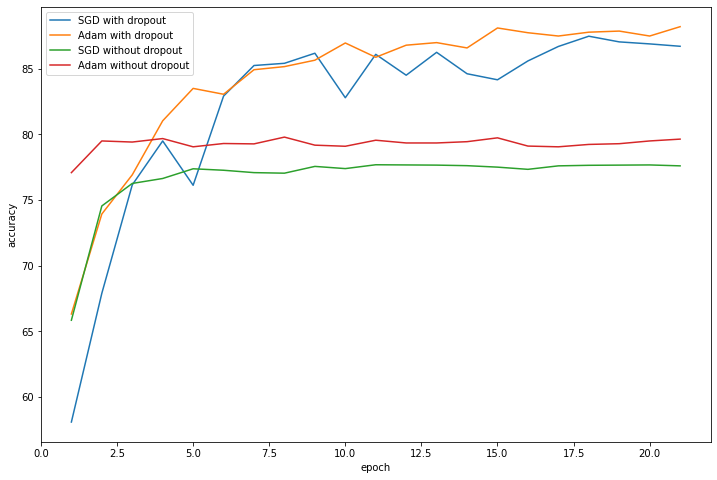

In [193]:
plt.figure(figsize=(12, 8)) 
plt.plot(range(1, epochs+1) , accuracy['SGD with dropout'], label = 'SGD with dropout')
plt.plot(range(1, epochs+1), accuracy['Adam with dropout'], label = 'Adam with dropout')
plt.plot(range(1, epochs+1), accuracy['SGD without dropout'], label = 'SGD without dropout')
plt.plot(range(1, epochs+1), accuracy['Adam without dropout'], label = 'Adam without dropout')

plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()

plt.show()